In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# Data preprocess

In [2]:
Iris_dataset = pd.read_table('iris.data', delimiter=',',header=None)

In [3]:
samples = np.zeros((Iris_dataset.shape[0], 4))
labels = np.zeros((Iris_dataset.shape[0], ))

In [4]:
dic = {}
for i,category in enumerate(Iris_dataset[4].unique()):
    dic[category] = i

In [5]:
for row in range(Iris_dataset.shape[0]):
    samples[row][0] = Iris_dataset.iloc[row][0]
    samples[row][1] = Iris_dataset.iloc[row][1]
    samples[row][2] = Iris_dataset.iloc[row][2]
    samples[row][3] = Iris_dataset.iloc[row][3]
                               
    labels[row] = dic[Iris_dataset.iloc[row][4]]

In [6]:
ground_truth = np.zeros([labels.shape[0], 3])

In [7]:
for i in range(labels.shape[0]):
    ground_truth[i][int(labels[i])] = 1

In [8]:
labels = ground_truth

In [9]:
train_data = np.zeros((120, 4))
train_label = np.zeros((120, 3))
test_data = np.zeros((30, 4))
test_label = np.zeros((30, 3))
for i in range(3):
    num = int(samples.shape[0]/3)
    idx = list(range(num * i, num * (i+1)))
    np.random.shuffle(idx)
    
    split = int(num * 0.8)
    test_num = num - split
    train_idx = idx[:split]
    test_idx = idx[split:]
    
    train_data[split * i: split * (i+1)] = samples[train_idx]
    test_data[test_num * i: test_num * (i+1)] = samples[test_idx]
    train_label[split * i: split * (i+1)] = labels[train_idx]
    test_label[test_num * i: test_num * (i+1)] = labels[test_idx]

In [10]:
idx = list(range(train_data.shape[0]))
np.random.shuffle(idx)

train_data = train_data[idx]
train_label = train_label[idx]

idx = list(range(test_data.shape[0]))
np.random.shuffle(idx)

test_data = test_data[idx]
test_label = test_label[idx]

# Define model

In [11]:
class ThreeLayerNet(object):

    def __init__(self, input_size, hidden_size, output_size, std=1e-3):

        """ Three layer net implemented with numpy
        Weights and biases are stored in the variable self.params, which is a dictionary with the following keys:
        W1: Hiden layer weights, shape (D, H)
        b1: Hiden layer biases, shape (H,)
        W2: Second layer weights, shape (H, C)
        b2: Second layer biases, shape (C,)

        :param input_size: The dimension D of the input data.
        :param hidden_size: The number of neurons H in the hidden layer.
        :param output_size: The number of classes C.

        """
        self.output_size = output_size
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def derivative_sigmoid(self, x):
        return np.dot(self.sigmoid(x).T, (1 - self.sigmoid(x)))

    def MSELoss(self, predict, ground_truth):
        return np.sum(0.5*(predict-ground_truth)**2)
    
    def softmax(self, x):
        exp_x = np.exp(x)
        tmp = np.sum(exp_x, axis=1).reshape(x.shape[0], 1)
        return exp_x / tmp

    def loss(self, X, y, reg=0.0):
        """Compute the loss and gradients, combining forward and backward
        :param X: training samples, shape (N, D)
        :param y: one-hot-coded training labels, shape (N，C)

        Returns:
        loss: Loss for this batch of training samples.
        grads: Dictionary mapping parameter names to gradients of those parameters

        """
        
        # Forward
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']

        a1 = X
        z1 = np.dot(a1, W1) + b1
        a2 = self.sigmoid(z1)
        z2 = np.dot(a2, W2) + b2

        loss = self.MSELoss(z2, y)

        # Backward pass: compute gradients
        grads = {}
        dW2 = np.dot(a2.T, z2 - y)
        dW2 += reg * dW2
        grads['W2'] = dW2
        grads['b2'] = np.sum(z2 - y, axis=0)

        da2 = np.dot((z2 - y), W2.T)
        dz1 = np.dot(da2, self.derivative_sigmoid(z1))
        dW1 = np.dot(a1.T, dz1)
        dW1 += reg * dW1
        grads['W1'] = dW1
        grads['b1'] = np.sum(dz1, axis=0)

        return loss, grads

    def train(self, X, y, learning_rate=1e-3, batch_size=3, reg=0.0):
        """Train the neural network
        :param X: training samples, shape (N, D)
        :param y: one-hot-coded training labels, shape (N, C)
        :param learning_rate: Scalar giving learning rate for optimization.
        :param batch_size: Number of training examples to use per step.
        
        Returns: loss and train_acc

        """

        num_train = X.shape[0]
        batch_num = max(num_train // batch_size, 1)

        total_loss = 0

        for idx in range(batch_num):

            X_batch = X[idx * batch_size : (idx+1) * batch_size]
            y_batch = y[idx * batch_size : (idx+1) * batch_size]

            loss, grads = self.loss(X_batch, y_batch, reg)
            total_loss += loss

            # Gradient Descent

            dW1, db1 = grads['W1'], grads['b1']
            dW2, db2 = grads['W2'], grads['b2']
            
            self.params['W1'] -= learning_rate * dW1
            self.params['b1'] -= learning_rate * db1
            self.params['W2'] -= learning_rate * dW2
            self.params['b2'] -= learning_rate * db2

        # Check accuracy
        _, y_pred = self.predict(X)
        y_true = y
        
        count = 0
        for i in range(y_pred.shape[0]):
            if all(y_pred[i] == y_true[i]):
                count += 1
        train_acc = count / num_train
        loss = total_loss / num_train

        return {
          'loss': loss,
          'train_acc': train_acc,
        }
    
    def test(self, X, y):
        """Test the neural network
        :param X: testing samples, shape (N, D)
        :param y: one-hot-coded testing labels, shape (N, C)
        
        Returns: loss and test_acc

        """
        num_test = X.shape[0]

        # Check accuracy
        output, y_pred = self.predict(X)
        y_true = y
        
        count = 0
        for i in range(y_pred.shape[0]):
            if all(y_pred[i] == y_true[i]):
                count += 1
        test_acc = count / num_test
        loss = self.MSELoss(output, y_true) / num_test

        return {
          'loss': loss,
          'test_acc': test_acc,
        }


    def predict(self, X):

        """predict label of sample X
        :param X: testing data, shape (N, D)

        Returns:
        pred: predicted one-hot coded labels, shape (N, C)

        """
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']

        a1 = X
        z1 = np.dot(a1, W1) + b1
        a2 = self.sigmoid(z1)
        z2 = np.dot(a2, W2) + b2
        y_pred = np.argmax(z2, axis=1)
        
        # one-hot
        pred = np.zeros([y_pred.shape[0],self.output_size])
        for i in range(y_pred.shape[0]):
            pred[i][int(y_pred[i])] = 1

        return z2, pred

# Train

In [12]:
input_size = train_data.shape[1]
output_size = labels.shape[1]

In [16]:
model = ThreeLayerNet(input_size, 40, output_size)

In [17]:
NUM_EPOCH = 800
learning_rate = 1e-3
batch_size = 5

train_loss = []
train_acc = []
test_loss = []
test_acc = []
for idx in range(NUM_EPOCH):
    train_res = model.train(train_data, train_label, learning_rate, batch_size, reg=1e-3)
    train_loss.append(train_res['loss'])
    train_acc.append(train_res['train_acc'])
    
    test_res = model.test(test_data, test_label)
    test_loss.append(test_res['loss'])
    test_acc.append(test_res['test_acc'])
    
    if (idx + 1) % 50 == 0:
        print('Epoch: %d  Train loss: %.3f  acc: %.3f  Test loss: %.3f acc: %.3f' % (idx, train_res['loss'], train_res['train_acc'], test_res['loss'], test_res['test_acc']))

Epoch: 49  Train loss: 0.228  acc: 0.667  Test loss: 0.221 acc: 0.667
Epoch: 99  Train loss: 0.182  acc: 0.692  Test loss: 0.180 acc: 0.667
Epoch: 149  Train loss: 0.178  acc: 0.758  Test loss: 0.176 acc: 0.733
Epoch: 199  Train loss: 0.177  acc: 0.767  Test loss: 0.174 acc: 0.733
Epoch: 249  Train loss: 0.176  acc: 0.750  Test loss: 0.173 acc: 0.800
Epoch: 299  Train loss: 0.176  acc: 0.758  Test loss: 0.173 acc: 0.800
Epoch: 349  Train loss: 0.175  acc: 0.767  Test loss: 0.172 acc: 0.833
Epoch: 399  Train loss: 0.175  acc: 0.767  Test loss: 0.172 acc: 0.833
Epoch: 449  Train loss: 0.174  acc: 0.783  Test loss: 0.171 acc: 0.833
Epoch: 499  Train loss: 0.173  acc: 0.800  Test loss: 0.170 acc: 0.900
Epoch: 549  Train loss: 0.172  acc: 0.833  Test loss: 0.169 acc: 0.900
Epoch: 599  Train loss: 0.171  acc: 0.875  Test loss: 0.167 acc: 0.900
Epoch: 649  Train loss: 0.168  acc: 0.942  Test loss: 0.165 acc: 0.933
Epoch: 699  Train loss: 0.166  acc: 0.958  Test loss: 0.162 acc: 0.967
Epoch: 7

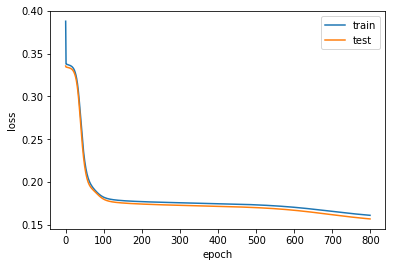

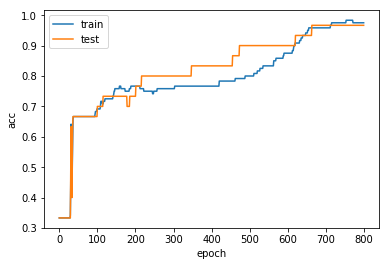

In [18]:
dir_path = './figures_numpy_net'
if not os.path.isdir(dir_path):
    os.mkdir(dir_path)

x = range(NUM_EPOCH)
plt.plot(x, train_loss, test_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'])
plt.savefig(os.path.join(dir_path, "loss.png"))
plt.show()
    
x = range(NUM_EPOCH)
plt.plot(x, train_acc, test_acc)
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train', 'test'])
plt.savefig(os.path.join(dir_path, "acc.png"))
plt.show()